In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from tqdm import tqdm

## Defining parameters

In [2]:
kappa =4
theta = 0.2
eta = 0.9
r = 0.02
rho = -1/2
T = 1
N = 1_000_000
M = 5
S0 = 100
v0 = 0.10



### **Heston Model Dynamics**

The Heston model consists of two stochastic differential equations that describe the dynamics of the stock price $S_t$ and its variance $\nu_t$.

#### **Stock Price Process**

The stock price follows the stochastic differential equation:

$$
dS_t = S_t \left( r \, dt + \sqrt{\nu_t} \, dW_t \right)
$$

- $S_t$ is the stock price at time $t$.
- $r$ is the risk-free interest rate.
- $\nu_t$ is the variance process.
- $dW_t$ is a standard Brownian motion.

#### **Variance Process**

The variance $\nu_t$ follows a mean-reverting Cox-Ingersoll-Ross (CIR) process:

$$
d\nu_t = \kappa (\theta - \nu_t) \, dt + \eta \sqrt{\nu_t} \, dW_t^\perp
$$

- $\nu_t$ is the variance at time $t$.
- $\kappa$ is the rate of mean reversion.
- $\theta$ is the long-term mean of the variance.
- $\eta$ is the volatility of the variance process.
- $dW_t^\perp$ is another Brownian motion correlated with $dW_t$, with correlation coefficient $\rho$.

#### **Correlation Between Brownian Motions**

The Brownian motions $dW_t$ and $dW_t^\perp$ are correlated as follows:

$$
\mathbb{E}[dW_t dW_t^\perp] = \rho \, dt
$$

- $\rho \in (-1, 1)$ is the constant correlation between the two Brownian motions.

#### **Feller Condition**

To ensure the variance process remains positive, the following condition (called the **Feller condition**) must hold:

$$
2\kappa \theta > \eta^2
$$

This ensures that the variance $\nu_t$ does not hit zero.

---

### **Summary of Parameters**

- $S_t$: Stock price at time $t$.
- $\nu_t$: Variance (volatility squared) at time $t$.
- $r$: Risk-free interest rate.
- $\kappa$: Rate of mean reversion of the variance.
- $\theta$: Long-term mean of the variance.
- $\eta$: Volatility of the variance process.
- $\rho$: Correlation between the two Brownian motions.
- $dW_t$: Brownian motion for the stock price.
- $dW_t^\perp$: Brownian motion for the variance, correlated with $dW_t$.

In [3]:
dt = T/N

brownian = np.random.multivariate_normal(
    [0,0], 
    [[1, rho],[rho,1]], 
    size=(M,N)
)
dW, dW_hat= brownian[:,:,0]*np.sqrt(dt), brownian[:,:,1]*np.sqrt(dt)


@njit()
def generate_trajectories():
    vt = np.zeros_like(dW_hat)
    St = np.zeros_like(vt)
    vt[:,0] = v0
    St[:, 0] = S0

    for t in range(1,N):
        vt[:, t] = vt[:,t-1 ] + kappa*(theta - vt[:, t-1]) * dt + eta* np.sqrt(vt[:, t-1])* dW_hat[:, t]
        # use abs or (vt)_+?
        # vt[:, t] = np.maximum(0, vt[:,t])
        vt[:, t] = np.abs(vt[:,t])

        # use r or r-v_t/2?  
        dSt = St[:,t-1]*((r-1/2*vt[:, -1] )*dt + np.sqrt(vt[:, t-1])* dW[:, t])
        St[:, t] = St[:, t-1] + dSt

    return St, vt

St, vt = generate_trajectories()

Text(0.5, 1.0, 'Risk free')

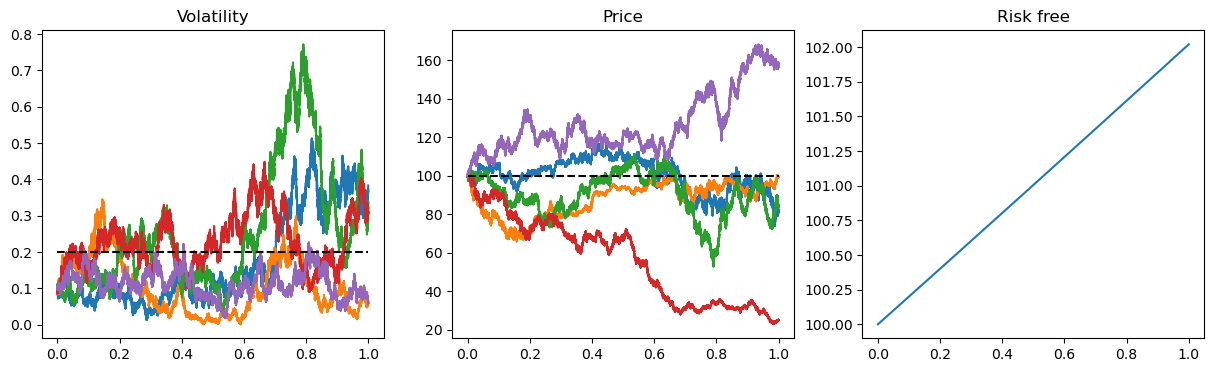

In [4]:
fig, ax = plt.subplots(1,3, figsize = (15,4))

t = np.arange(0,T, dt)
ax[0].plot(t, vt.T)
ax[0].set_title("Volatility")
ax[0].hlines(theta, 0, T, linestyles = 'dashed', color = 'black')
ax[1].plot(t, St.T)
ax[1].set_title("Price")
ax[1].hlines(S0, 0, T, linestyles = 'dashed', color = 'black')

ax[2].plot(t, S0* np.exp(r*t).T)
ax[2].set_title("Risk free")

## Stochastic volatility trees


$$
V^{(n)} := \max_{\tau \in \mathcal{T}_n} \mathbb{E}^{(n)} \left( e^{-r \tau h} \left( K - S_0 e^{\hat{X}_\tau^{(n)}} \right)^+ \right)
$$




We describe a dynamical programming algorithm for the calculation of $V^{(n)}$. Observe that for a given $k \in \{0, \dots, n\}$, the random variables $X_k^{(n)}$ and $Y_k^{(n)}$ take values on the grid:

$$
x_0 + (2l - k) \sqrt{\eta h}, \quad 0 \leq l \leq k,
$$

and

$$
y_0 + (2m - k) \sqrt{\eta (1 - \rho^2) h}, \quad 0 \leq m \leq k,
$$

respectively. For nonnegative integers $m, l \leq k \leq n$ and $\xi_X, \xi_Y \in \{-1, +1\}$, let

$$
V_k^{(n)}(l, m, \xi_X, \xi_Y)
$$

be the value of the option at time $k$.

We continue by rewriting the dynamic programming equation in an algorithmic manner. In view of (3.11)–(3.13), for any $1 \leq k \leq n$ and $0 \leq l, m \leq k - 1$, we define:

$$
\mathcal{X}_k := x_0 + (2l - k) \sqrt{\eta h},
$$

$$
\mathcal{Y}_k := y_0 + (2m - k) \sqrt{\eta (1 - \rho^2) h},
$$

where both of the above are functions of $(l, m)$, but this dependence is suppressed in the notation. Similarly, we define two probabilities:

$$
p_k(l, m, \xi_X, \xi_Y) := \frac{\exp(rh + \sqrt{\eta h} \Psi_k l - \xi_X) - \exp(-\sqrt{\eta h} \Psi_k)}{\exp(\sqrt{\eta h} \Psi_k) - \exp(-\sqrt{\eta h} \Psi_k)},
$$

$$
q_k(l, m, \xi_X, \xi_Y) := \left( \min \left\{ 1, \frac{1}{2} + \frac{\alpha_{k-1}(l - \xi_X, m - \xi_Y)\xi_Y}{2 \Psi_k} + \frac{\sqrt{h} \mu_{y,k}}{2\sqrt{\eta (1 - \rho^2)} \Psi_k} \right\} \right)^+,
$$

where $\alpha_0^{(n)} \equiv 0$ and

$$
\alpha_k(l, m) := \frac{\max(A_n, \sigma^2(\mathcal{X}_{k-1}, \mathcal{Y}_{k-1})) - 1}{2},
$$

$$
\Psi_k := 1 + \alpha_k^{(n)}(l, m),
$$

$$
\mu_{y,k} := \mu_y(\mathcal{X}_{k-1}, \mathcal{Y}_{k-1}).
$$


We are now ready to restate the dynamic programming equation (5.1). Indeed, $V_k^{(n)}(l, m, \xi_X, \xi_Y)$ is the unique solution of the following recursive relations:

$$
V_n^{(n)}(l, m, \xi_X, \xi_Y) = \left( K - \exp \left( X_n + \sqrt{\eta h} \alpha_n \xi_X \right) \right)^+,
$$

and for $1 \leq k \leq n$,

$$
V_{k-1}^{(n)}(l, m, \xi_X, \xi_Y) = \max \left\{ \left( K - \exp \left( X_{k-1} + \sqrt{\eta h} \alpha_{k-1} \xi_X \right) \right)^+, \mathcal{E}(V_k^{(n)}) \right\},
$$

where $ \mathcal{E}(V_k^{(n)})$

is given by

$$
\mathcal{E}(V_k^{(n)}) = \mathbb{E}^{(n)} \left[ V_k^{(n)}(\Xi_k) \big| \Xi_{k-1} = F_{k-1}(l, m, \xi_X, \xi_Y) \right]
$$

and can be written as:

$$
\mathcal{E}(V_k^{(n)}) = \frac{1}{4} \sum_{i, j = 0}^1 \mathbb{P}_k^{(n)}(\xi_k^X = 2i - 1, \xi_k^Y = 2j - 1) V_k^{(n)}(l + i, m + j, 2i - 1, 2j - 1)
$$



In [5]:
# the algorithm
K = 100 # strike
h = dt
x0 = np.log(S0)
y0 = v0/eta - rho*x0
A = (kappa*theta/eta - np.abs(rho)*r)*np.sqrt(h/(eta*(1-rho**2)))

In [6]:
def get_XY(k, l, m):
    Xk = x0 + (2*l - k)*np.sqrt(eta*h)
    Yk = y0 + (2*m-k) * np.sqrt(eta*h*(1-rho**2))

    return Xk, Yk

In [7]:
def sigma(x,y):
    return np.sqrt(np.maximum(0, y + rho * x))

def mu_X(x,y):
    return r - 1/2*eta*(y + rho *x)

def mu_Y(x,y):
    return kappa*theta/eta - rho*r + 1/2*(rho*eta - 2*kappa)*(y+rho*x)

def alpha(k, l, m):
    if k == 0:
        return 0
    
    X_k_1, Y_k_1 = get_XY(k-1, l, m)
    return (np.maximum(A, sigma(X_k_1, Y_k_1)) - 1)/2

In [8]:
N = 50

In [9]:
def current_payoff(
    k,
    l,
    m,
    eX, 
    h,
    g : callable = lambda x, strike: np.maximum(strike-x, 0),
):
    X_k, _ = get_XY(k, l, m)
    S_k = np.exp(X_k + np.sqrt(h*eta) * alpha(k, l, m)*eX)

    return g(S_k, K)

memo = {}

def compute_option_value(k,l,m, eX, eY, N):
    h = T/N

    if (k,l,m,eX,eY) in memo:
        return memo[(k,l,m,eX,eY)] 


    phi_k = 1 + alpha(k,l,m)
    phi_k_1 = 1 + alpha(k-1,l,m)

    X_k_1, Y_k_1 = get_XY(k, l, m)

    pk = (np.exp(r*h + np.sqrt(eta*h)* phi_k_1 *eX) - np.exp(-np.sqrt(eta*h)*phi_k))/(np.exp(np.sqrt(eta*h)*phi_k) - np.exp(-np.sqrt(eta*h)*phi_k))
    qk = np.minimum(1.,1/2 + alpha(k-1, l - eX, m- eY)*eY/(2*phi_k) + np.sqrt(h/(eta*(1-rho**2)))*mu_Y(X_k_1, Y_k_1)/(2*phi_k))
    qk = np.maximum(0., qk)

    if k == N:
        return current_payoff(N, l ,m , eX, h)


    epsilon_V = 0 # continuation value
    for i in [0,1]:
        for j in [0,1]:
            epsilon_V += (1-i + (2*i-1)*pk)*(1-j+ (2*j-1)*qk)*compute_option_value(k+1,l+i,m+j, 2*i-1, 2*j-1, N)
            

    memo[(k,l,m,eX,eY)] = np.maximum(epsilon_V, current_payoff(k,l,m,eX, h))
    return np.maximum(epsilon_V, current_payoff(k,l,m,eX, h))
    

In [10]:
value = compute_option_value(0,0,0,0,0, N)

In [11]:
value

2.5593469246784055

### Using binomial model

In [12]:


def price_american_put_binomial(S0, K, r, sigma, T, N):
    """
    Price an American put option using the binomial tree model.

    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - r: Risk-free interest rate
    - sigma: Volatility of the underlying asset
    - T: Time to maturity
    - N: Number of time steps

    Returns:
    - Estimated option price
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u                        # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability
    discount = np.exp(-r * dt)          # Discount factor

    # Initialize asset prices at maturity
    asset_prices = np.zeros(N + 1)
    for i in range(N + 1):
        asset_prices[i] = S0 * (u ** i) * (d ** (N - i))

    # Initialize option values at maturity (put payoff)
    option_values = np.maximum(K - asset_prices, 0)

    # Work backward through the tree
    for t in range(N - 1, -1, -1):
        for i in range(t + 1):
            asset_prices[i] = S0 * (u ** i) * (d ** (t - i))
            continuation_value = discount * (p * option_values[i + 1] + (1 - p) * option_values[i])
            exercise_value = K - asset_prices[i]
            option_values[i] = max(exercise_value, continuation_value)  # American option can be exercised early
    
    return option_values[0]





In [13]:
# Parameters
N = 50        # Number of time steps

# Calculate option price

option_price = price_american_put_binomial(S0, K, r, theta, T, N)
print(f"Estimated American put option price (Binomial Tree): {option_price:.4f}")

Estimated American put option price (Binomial Tree): 7.0877


In [14]:
N = 50
values_binomial = np.zeros(N)
values_heston = np.zeros_like(values_binomial)

for i in tqdm(range(1,N+1)):
    values_binomial[i-1] = price_american_put_binomial(S0, K, r, np.sqrt(theta), T, i)
    memo = {}
    values_heston[i-1] = compute_option_value(0,0,0,0,0,i)

100%|██████████| 50/50 [03:34<00:00,  4.30s/it]


### Using Longstaff-Schwarz

In [15]:
def generate_asset_prices(S0, r, sigma, T, M, N):
    """
    Generate asset price paths using geometric Brownian motion.

    Parameters:
    - S0: Initial stock price
    - r: Risk-free interest rate
    - sigma: Volatility of the underlying asset
    - T: Time to maturity
    - M: Number of time steps
    - N: Number of simulated paths

    Returns:
    - A numpy array of shape (N, M+1) containing the simulated asset prices
    """
    dt = T / M
    t = np.linspace(0, T, M+1)
    dW = np.sqrt(dt) * np.random.randn(N, M)
    W = np.cumsum(dW, axis=1)
    W = np.hstack((np.zeros((N, 1)), W))
    exponent = (r - 0.5 * sigma ** 2) * t + sigma * W
    S = S0 * np.exp(exponent)
    return S

def price_american_put_longstaff_schwartz(S0, K, r, sigma, T, M, N):
    """
    Price an American put option using the Longstaff-Schwartz method.

    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - r: Risk-free interest rate
    - sigma: Volatility of the underlying asset
    - T: Time to maturity
    - M: Number of time steps
    - N: Number of simulated paths

    Returns:
    - Estimated option price
    """
    dt = T / M
    discount_factor = np.exp(-r * dt)

    # Generate asset price paths
    S = generate_asset_prices(S0, r, sigma, T, M, N)

    # Initialize cash flows
    cash_flows = np.maximum(K - S[:, -1], 0)

    # Loop backward in time
    for t in range(M - 1, 0, -1):
        # Indices of paths where the option is in the money
        in_the_money = np.where(K - S[:, t] > 0)[0]

        if len(in_the_money) == 0:
            continue

        # Prepare regression
        X = S[in_the_money, t]
        Y = cash_flows[in_the_money] * discount_factor

        # Basis functions (e.g., polynomials)
        A = np.vstack([np.ones_like(X), X, X**2]).T

        # Perform linear regression to estimate continuation values
        coeffs = np.linalg.lstsq(A, Y, rcond=None)[0]
        continuation_values = A @ coeffs

        # Immediate exercise value
        exercise_values = K - X

        # Decide whether to exercise
        exercise = exercise_values > continuation_values

        # Update cash flows
        cash_flows[in_the_money[exercise]] = exercise_values[exercise]
        cash_flows[in_the_money[~exercise]] *= discount_factor

    # Discount cash flows to present value
    option_price = np.mean(cash_flows * np.exp(-r * dt))

    return option_price

In [16]:
M = 100
values_ls = np.zeros(N)

for i in tqdm(range(1,N+1)):
    values_ls[i-1] = price_american_put_longstaff_schwartz(S0, K, r, np.sqrt(theta), T, M, i)

100%|██████████| 50/50 [00:00<00:00, 112.96it/s]


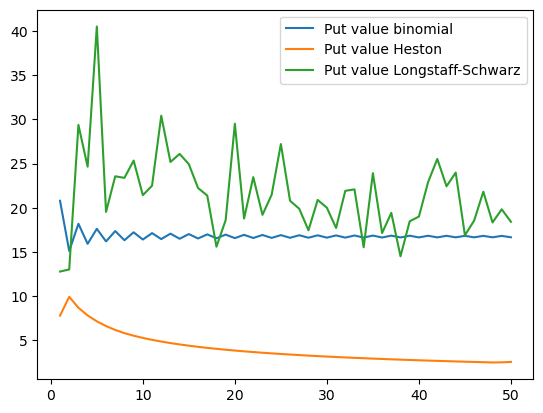

In [18]:
x = np.arange(1,N+1)
plt.plot(x, values_binomial, label = "Put value binomial")
plt.plot(x, values_heston, label = "Put value Heston")
plt.plot(x, values_ls, label = "Put value Longstaff-Schwarz")
plt.legend()